In [1]:
from mira.sources.system_dynamics import *
from mira.modeling.amr.stockflow import *
from mira.metamodel import *
from mira.sources.amr.stockflow import (
    template_model_from_amr_json as stockflow_amr_to_tm,
)
from mira.modeling.amr.ops import *
from mira.metamodel.ops import *
import pandas as pd

pd.set_option("display.max_colwidth", None)
scenario_4_url = "https://raw.githubusercontent.com/DARPA-ASKEM/program-milestones/main/18-month-milestone/evaluation/Epi%20Use%20Case/Scenario%204%20Supplementary/stock_flow_evaluation.mdl"

## Convert the Vensim model into a MIRA template model

In [2]:
old_tm = template_model_from_mdl_url(scenario_4_url)

could not ground deaths
could not ground exposed
could not ground infected
could not ground recovered
could not ground susceptible


## Visualize the unmodified template model

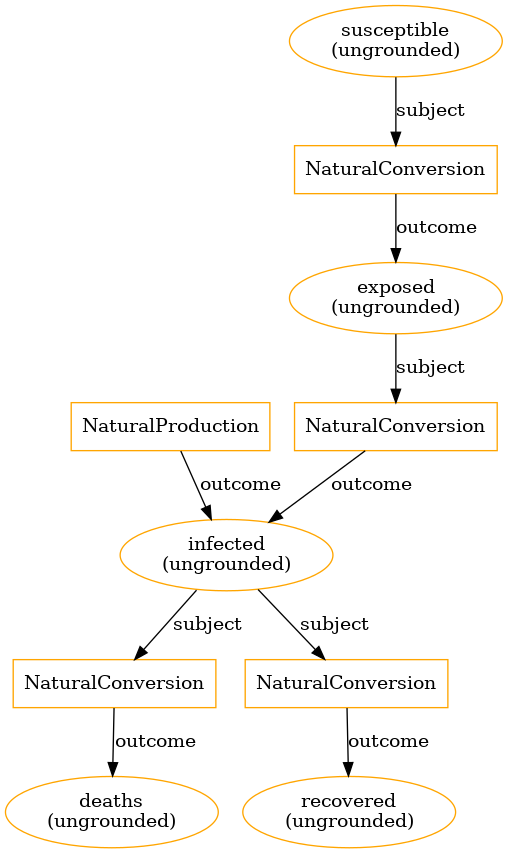

In [3]:
old_tm.draw_jupyter()

## Inspect the parameters, initial values, and rate laws of the template model

In [4]:
initial_values = [initial.expression for initial in old_tm.initials.values()]
df_initials = pd.DataFrame(
    {"Stock": list(old_tm.initials.keys()), "Initial Value": initial_values}
)
df_initials

,Stock,Initial Value
0,deaths,0.0
1,exposed,0.0
2,infected,0.0
3,recovered,0.0
4,susceptible,100000.0


In [5]:
param_values = [param.value for param in old_tm.parameters.values()]
df_param = pd.DataFrame(
    {
        "Parameter Name": list(old_tm.parameters.keys()),
        "Parameter Value": param_values,
    }
)
df_param

,Parameter Name,Parameter Value
0,initial_population,100000.00
1,seasonal_period,365.00
2,peak_season,0.00
3,seasonal_amplitude,0.00
4,contact_density_decline,0.00
5,potential_isolation_effectiveness,0.00
6,public_health_capacity_sensitivity,2.00
7,public_health_capacity,1000.00
8,hospital_capacity_sensitivity,2.00
9,hospital_capacity,100.00


In [6]:
rate_laws = [template.rate_law for template in old_tm.templates]
template_names = [template.name for template in old_tm.templates]
df_templates = pd.DataFrame(
    {"Template ID": template_names, "Rate Law": rate_laws}
)
df_templates

,Template ID,Rate Law
0,1,exposed/incubation_time
1,2,infected*(untreated_fatality_rate + (treated_fatality_rate - untreated_fatality_rate)/((fraction_requiring_hospitalization*infected/hospital_capacity)**hospital_capacity_sensitivity + 1))/infection_duration
2,3,"n_imported_infections*pulse(import_time, time_step)/time_step"
3,4,"infected*r0*susceptible*(1 - smooth3(step(potential_isolation_effectiveness, import_time), isolation_reaction_time)/(public_health_strain**public_health_capacity_sensitivity + 1))*(seasonal_amplitude*(cos((-6.28318*peak_season + 6.28318*time)/seasonal_period) + 1)/2 - seasonal_amplitude + 1)*smooth3(1 - step(behavioral_risk_reduction, import_time), behavior_reaction_time)/(infection_duration*initial_population*(contact_density_decline*(1 - susceptible/initial_population) + 1))"
4,5,infected*(-untreated_fatality_rate - (treated_fatality_rate - untreated_fatality_rate)/((fraction_requiring_hospitalization*infected/hospital_capacity)**hospital_capacity_sensitivity + 1) + 1)/infection_duration


## Export the template model to stock flow amr and verify if it has been exported correctly

In [7]:
amr = template_model_to_stockflow_json(old_tm)

In [8]:
amr["model"]["stocks"]

[{'id': 'exposed',
  'name': 'exposed',
  'grounding': {'identifiers': {}, 'modifiers': {}},
  'units': {'expression': 'people', 'expression_mathml': '<ci>people</ci>'}},
 {'id': 'infected',
  'name': 'infected',
  'grounding': {'identifiers': {}, 'modifiers': {}},
  'units': {'expression': 'people', 'expression_mathml': '<ci>people</ci>'}},
 {'id': 'deaths',
  'name': 'deaths',
  'grounding': {'identifiers': {}, 'modifiers': {}},
  'units': {'expression': 'people', 'expression_mathml': '<ci>people</ci>'}},
 {'id': 'susceptible',
  'name': 'susceptible',
  'grounding': {'identifiers': {}, 'modifiers': {}},
  'units': {'expression': 'people', 'expression_mathml': '<ci>people</ci>'}},
 {'id': 'recovered',
  'name': 'recovered',
  'grounding': {'identifiers': {}, 'modifiers': {}},
  'units': {'expression': 'people', 'expression_mathml': '<ci>people</ci>'}}]

In [9]:
amr["semantics"]["ode"]["initials"]

[{'target': 'exposed',
  'expression': '0.0',
  'expression_mathml': '<cn>0.0</cn>'},
 {'target': 'infected',
  'expression': '0.0',
  'expression_mathml': '<cn>0.0</cn>'},
 {'target': 'deaths',
  'expression': '0.0',
  'expression_mathml': '<cn>0.0</cn>'},
 {'target': 'susceptible',
  'expression': '100000.0',
  'expression_mathml': '<cn>100000.0</cn>'},
 {'target': 'recovered',
  'expression': '0.0',
  'expression_mathml': '<cn>0.0</cn>'}]

In [10]:
amr["semantics"]["ode"]["parameters"]

[{'id': 'incubation_time',
  'description': 'Time to onset of symptoms among exposed people.',
  'value': 5.0,
  'units': {'expression': 'day', 'expression_mathml': '<ci>day</ci>'}},
 {'id': 'fraction_requiring_hospitalization',
  'description': 'Fraction of infected who require hospitalization.',
  'value': 0.1},
 {'id': 'hospital_capacity',
  'description': 'Hospital capacity, expressed as number of serious infected cases that can be handled given beds, staff, etc.',
  'value': 100.0,
  'units': {'expression': 'people', 'expression_mathml': '<ci>people</ci>'}},
 {'id': 'hospital_capacity_sensitivity',
  'description': 'Sensitivity of care quality to capacity.',
  'value': 2.0,
  'units': {'expression': 'dmnl', 'expression_mathml': '<ci>dmnl</ci>'}},
 {'id': 'infection_duration',
  'description': 'Duration of infection. As a simplification, this is the same for cases resulting in recovery and death, though in reality serious cases have longer duration.',
  'value': 7.0,
  'units': {'e

In [11]:
amr["model"]["flows"]

[{'id': '1',
  'name': 'advancing',
  'upstream_stock': 'exposed',
  'downstream_stock': 'infected',
  'rate_expression': 'exposed/incubation_time',
  'rate_expression_mathml': '<apply><divide/><ci>exposed</ci><ci>incubation_time</ci></apply>'},
 {'id': '2',
  'name': 'dying',
  'upstream_stock': 'infected',
  'downstream_stock': 'deaths',
  'rate_expression': 'infected*(untreated_fatality_rate + (treated_fatality_rate - untreated_fatality_rate)/((fraction_requiring_hospitalization*infected/hospital_capacity)**hospital_capacity_sensitivity + 1))/infection_duration',
  'rate_expression_mathml': '<apply><divide/><apply><times/><ci>infected</ci><apply><plus/><ci>untreated_fatality_rate</ci><apply><divide/><apply><minus/><ci>treated_fatality_rate</ci><ci>untreated_fatality_rate</ci></apply><apply><plus/><apply><power/><apply><divide/><apply><times/><ci>fraction_requiring_hospitalization</ci><ci>infected</ci></apply><ci>hospital_capacity</ci></apply><ci>hospital_capacity_sensitivity</ci></a

## Import the stock flow amr back to a MIRA template model

In [12]:
new_tm = stockflow_amr_to_tm(amr)

## Define methods used to add states, add and remove transitions

In [13]:
def add_state(
    tm,
    state_id,
    name: str = None,
    units_mathml: str = None,
    grounding: Mapping[str, str] = None,
    context: Mapping[str, str] = None,
):
    assert isinstance(tm, TemplateModel)
    if units_mathml:
        units = Unit(
            expression=SympyExprStr(mathml_to_expression(units_mathml))
        )
    else:
        units = None

    new_concept = Concept(
        name=state_id,
        display_name=name,
        identifiers=grounding,
        context=context,
        units=units,
    )
    static_template = StaticConcept(subject=new_concept)
    tm.templates.append(static_template)
    return tm


def add_transition(
    tm,
    new_transition_id: str,
    src_id: str = None,
    tgt_id: str = None,
    rate_law_mathml: str = None,
    params_dict: Mapping = None,
):
    if src_id is None and tgt_id is None:
        ValueError("You must pass in at least one of source and target id")
    if (
        src_id not in tm.get_concepts_name_map()
        and tgt_id not in tm.get_concepts_name_map()
    ):
        ValueError(
            "At least src_id or tgt_id must correspond to an existing concept in the template model"
        )
    rate_law_sympy = (
        SympyExprStr(mathml_to_expression(rate_law_mathml))
        if rate_law_mathml
        else None
    )

    subject_concept = tm.get_concepts_name_map().get(src_id)
    outcome_concept = tm.get_concepts_name_map().get(tgt_id)

    tm = tm.add_transition(
        transition_name=new_transition_id,
        subject_concept=subject_concept,
        outcome_concept=outcome_concept,
        rate_law_sympy=rate_law_sympy,
        params_dict=params_dict,
    )
    return tm


def remove_transition(model, transition_id: str):
    assert isinstance(model, TemplateModel)
    tm = model
    tm.templates = [t for t in tm.templates if t.name != transition_id]
    return tm

## Add two new states which split the "infected" stock, and add new transitions to prior existing states to the new states, and remove transitions involving the "infected" stock

In [14]:
new_tm = add_state(old_tm, "symptomatic_infected", context={}, grounding={})
new_tm = add_state(new_tm, "asymptomatic_infected", context={}, grounding={})
new_tm = add_transition(
    new_tm, "infecting_asymptomatic", "exposed", "asymptomatic_infected"
)
new_tm = add_transition(
    new_tm, "infecting_symptomatic", "exposed", "symptomatic_infected"
)
new_tm = add_transition(
    new_tm, "infecting_asymptomatic_death", "asymptomatic_infected", "deaths"
)
new_tm = add_transition(
    new_tm,
    "infecting_asymptomatic_recovered",
    "asymptomatic_infected",
    "recovered",
)
new_tm = add_transition(
    new_tm, "infecting_symptomatic_death", "symptomatic_infected", "deaths"
)
new_tm = add_transition(
    new_tm,
    "infecting_symptomatic_recovered",
    "symptomatic_infected",
    "recovered",
)
new_tm = remove_transition(new_tm, "1")
new_tm = remove_transition(new_tm, "2")
new_tm = remove_transition(new_tm, "3")
new_tm = remove_transition(new_tm, "5")
new_tm.templates = [
    template for template in new_tm.templates if type(template) != StaticConcept
]

## Visualize the new template model 

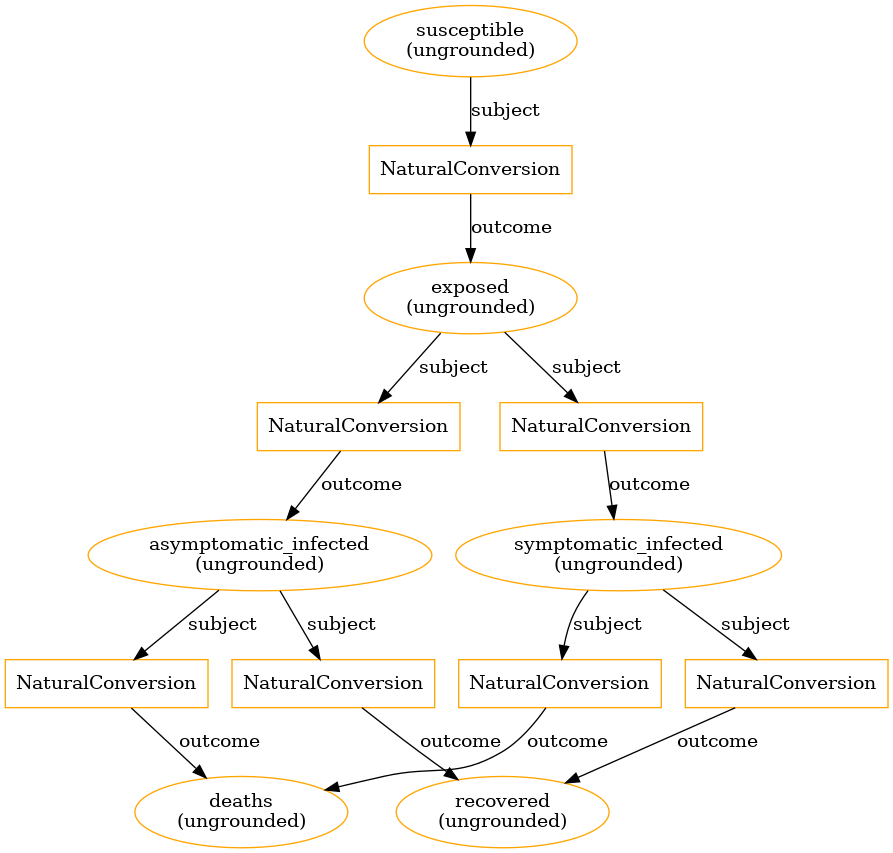

In [15]:
new_tm.draw_jupyter()